<a href="https://colab.research.google.com/github/TaarMaan/-TaarMaan-Lrn1_Artamonov_Smirnov/blob/main/Lrn1_Artamonov_Smirnov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Directive pour afficher les graphiques dans Jupyter
%matplotlib inline

# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn import datasets


In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16


In [ ]:
import cv2
import os
import glob
import gc
def load_images(img_dir, xdim, ydim, nmax=5000) :
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'**')
        #print(data_path)
        files = [os.path.normpath(i) for i in glob.glob(data_path)]
        #print(files)
        n=0
        for f1 in files:
            if n>nmax : break
            img = cv2.imread(f1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (xdim,ydim))
            X.append(np.array(img))
            y.append(label)
            n=n+1
        print(n,' loaded')
        label = label+1
    X = np.array(X)
    y = np.array(y)
    gc.collect()
    return X,y, label, label_names

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
Images,Labels,N_classes,name_classes = load_images("/content/drive/MyDrive/LrN1/fruits-360-original-size/fruits-360-original-size/Training", 100, 100, 500)
print("Начинаем загружать тестовый набор")
Images_test,Labels_test,N_classes_test,name_classes_test = load_images("/content/drive/MyDrive/LrN1/fruits-360-original-size/fruits-360-original-size/Test", 100, 100, 500)
print("Данные успешно загружены")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
apple_6
315  loaded
apple_braeburn_1
320  loaded
apple_crimson_snow_1
318  loaded
apple_golden_1
308  loaded
apple_golden_2
308  loaded
apple_golden_3
316  loaded
apple_granny_smith_1
320  loaded
apple_hit_1
468  loaded
apple_pink_lady_1
313  loaded
apple_red_1
309  loaded
apple_red_2
318  loaded
apple_red_3
281  loaded
apple_red_delicios_1
300  loaded
apple_red_yellow_1
308  loaded
apple_rotten_1
319  loaded
cabbage_white_1
96  loaded
carrot_1
101  loaded
cucumber_1
100  loaded
cucumber_3
163  loaded
eggplant_violet_1
160  loaded
pear_1
326  loaded
pear_3
144  loaded
zucchini_1
160  loaded
zucchini_dark_1
160  loaded
Начинаем загружать тестовый набор
apple_6
157  loaded
apple_braeburn_1
160  loaded
apple_crimson_snow_1
159  loaded
apple_golden_1
154  loaded
apple_golden_2
154  loaded
apple_golden_3
158  loaded
apple_granny_smith_1
160  loaded
apple_hit_1
234

In [ ]:
Images.shape

(6231, 100, 100, 3)

In [ ]:
Images_test.shape

(3110, 100, 100, 3)

In [ ]:
Labels

array([ 0,  0,  0, ..., 23, 23, 23])

In [ ]:
Labels_test

array([ 0,  0,  0, ..., 23, 23, 23])

In [ ]:
batch_size = 32
img_height = 100
img_width = 100

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LrN1/fruits-360-original-size/fruits-360-original-size/Training",
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LrN1/fruits-360-original-size/fruits-360-original-size/Training",
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)


Found 6231 files belonging to 24 classes.
Using 4985 files for training.
Found 6231 files belonging to 24 classes.
Using 1246 files for validation.
(32, 100, 100, 3)
(32,)


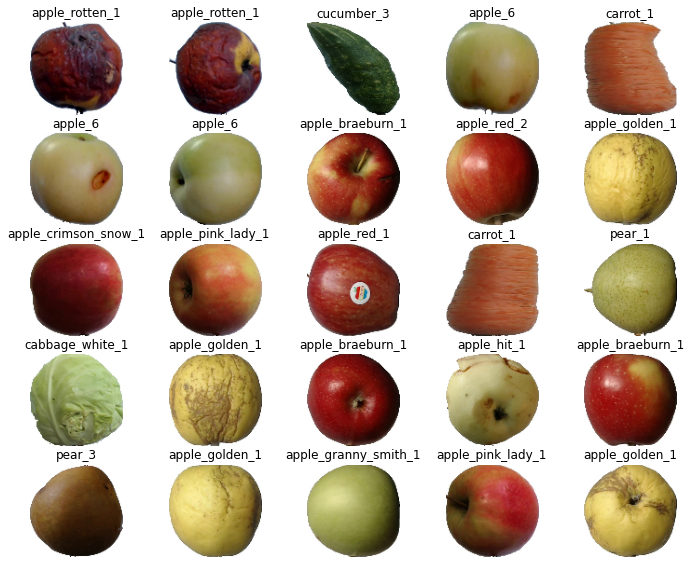

In [ ]:
import random
plt.figure(figsize=(12,20))
for i in range(0,25) :
    plt.subplot(10,5,i+1)
    j = random.randint(0,len(Images))
    plt.axis('off')
    plt.imshow(Images[j])
    plt.title(name_classes[Labels[j]])

In [ ]:
#Создаем модель
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model = tf.keras.applications.resnet.ResNet50(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 100, 100, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 100, 100, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [ ]:
#Тренируем модель
epochs = 10

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)


Epoch 1/10
156/156 [==============================] - 34s 64ms/step - loss: 2.5215 - accuracy: 0.2859 - val_loss: 1.4733 - val_accuracy: 0.5474
Epoch 2/10
156/156 [==============================] - 6s 42ms/step - loss: 1.1219 - accuracy: 0.6554 - val_loss: 0.8522 - val_accuracy: 0.7689
Epoch 3/10
156/156 [==============================] - 7s 42ms/step - loss: 0.7189 - accuracy: 0.7898 - val_loss: 0.5996 - val_accuracy: 0.8612
Epoch 4/10
156/156 [==============================] - 6s 41ms/step - loss: 0.5316 - accuracy: 0.8485 - val_loss: 0.4677 - val_accuracy: 0.8917
Epoch 5/10
156/156 [==============================] - 6s 41ms/step - loss: 0.4146 - accuracy: 0.8897 - val_loss: 0.3825 - val_accuracy: 0.9133
Epoch 6/10
156/156 [==============================] - 6s 41ms/step - loss: 0.3472 - accuracy: 0.9099 - val_loss: 0.3187 - val_accuracy: 0.9422
Epoch 7/10
156/156 [==============================] - 7s 43ms/step - loss: 0.2919 - accuracy: 0.9222 - val_loss: 0.2826 - val_accuracy: 0.946

In [ ]:
def plot_scores(history) :
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Обучение')
    plt.plot(epochs, val_accuracy, 'r', label='Валидация')
    plt.title('Точность обучения')
    plt.legend()
    plt.show()

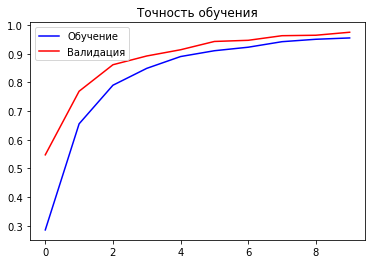

In [ ]:
plot_scores(history)

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
train_loss
val_loss

[1.4733004570007324,
 0.8522486090660095,
 0.5995578169822693,
 0.46768492460250854,
 0.38254642486572266,
 0.31874793767929077,
 0.28257954120635986,
 0.23838230967521667,
 0.21586400270462036,
 0.18698176741600037]

In [ ]:
np.argmin(val_loss)

9

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/LrN1/fruits-360-original-size/fruits-360-original-size/Test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names_test = test_ds.class_names
num_classes = len(class_names)

Found 3110 files belonging to 24 classes.


In [ ]:
scores = model.evaluate(test_ds)

98/98 [==============================] - 8s 77ms/step - loss: 0.1718 - accuracy: 0.9778


In [ ]:
print('Test loss ', scores[0])
print('Test accuracy ', scores[1])

Test loss  0.17182601988315582
Test accuracy  0.9778134822845459


In [ ]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [ ]:
predictions = probability_model.predict(image_batch)

In [ ]:
predictions[0]

array([4.8246619e-08, 5.0820365e-08, 3.5689391e-09, 9.9815434e-01,
       1.2566928e-05, 9.5241594e-06, 1.0442346e-08, 1.3387827e-03,
       4.7731483e-08, 3.9274603e-08, 1.0681194e-06, 2.3340413e-05,
       1.4236987e-07, 1.7816812e-04, 6.4266678e-06, 3.3945398e-07,
       4.4114799e-07, 5.7109270e-07, 3.8253762e-07, 1.9398475e-07,
       6.1673832e-06, 2.6330535e-04, 3.6962872e-06, 3.1949020e-07],
      dtype=float32)

In [ ]:
np.argmax(predictions[0])

3

In [ ]:
labels_batch[0]

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(24))
  plt.yticks([])
  thisplot = plt.bar(range(24), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [ ]:
for image_batch1, labels_batch1 in test_ds.take(1):
    print(image_batch1.shape)
    print(labels_batch1.shape)

(32, 100, 100, 3)
(32,)


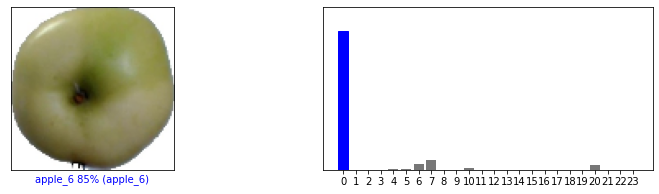

In [ ]:
i = 20
plt.figure(figsize=(13,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], Labels_test, Images_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  Labels_test)
plt.show()

In [ ]:
image_batch = image_batch / 255.0

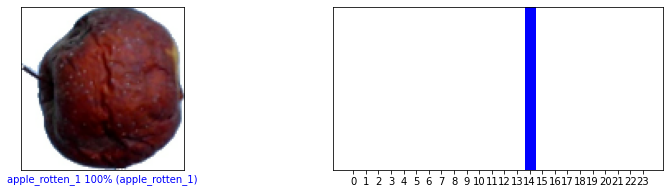

In [ ]:
i = 12
plt.figure(figsize=(13,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], labels_batch, image_batch)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  labels_batch)
plt.show()

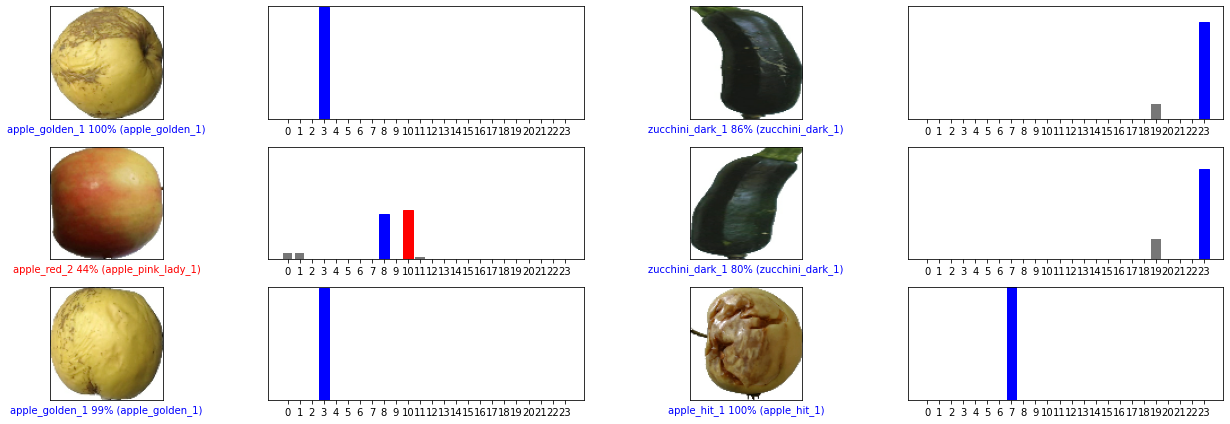

In [ ]:
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(3*3*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], labels_batch, image_batch)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], labels_batch)
plt.tight_layout()
plt.show()

In [ ]:
img = image_batch[1]

print(img.shape)

(100, 100, 3)


In [ ]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 100, 100, 3)


In [ ]:
predictions_single = probability_model.predict(img)

print(predictions_single)

[[1.3503197e-02 4.3479847e-03 4.2287549e-03 1.3454027e-04 3.8744458e-03
  2.7423887e-02 1.4696912e-02 4.3062042e-03 1.9505075e-03 5.7589733e-03
  3.8599458e-02 4.0230238e-01 6.9877669e-02 5.9701610e-02 1.2491380e-03
  3.7246204e-03 3.7318695e-02 9.7061126e-03 1.0496053e-01 7.0293762e-02
  9.5758531e-03 1.2291726e-02 3.7764590e-02 6.2408388e-02]]


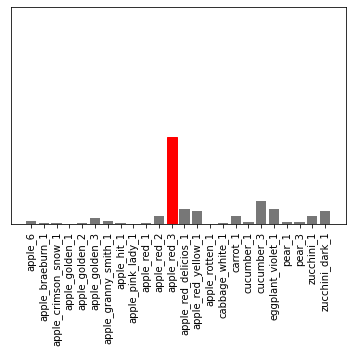

In [ ]:
plot_value_array(0, predictions_single[0], labels_batch)
_ = plt.xticks(range(24), class_names, rotation=90)
plt.show()

In [ ]:
np.argmax(predictions_single[0])

11

In [ ]:
from PIL import Image
from skimage.io import imread

def predict(file_name):
    img = Image.open(file_name)
    img = img.convert("RGB")
    img = img.resize((100, 100))
    img.save(file_name)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    img = imread(file_name)
    img = tf.keras.applications.densenet.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    probs = model.predict(img)
    for idx in probs.argsort()[0][::-1][:2]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", name_classes[idx])

def download_and_predict(url, file_name):
    os.system("curl -s {} -o {}".format(url, file_name))
    predict(file_name)

44.84% 	 zucchini_dark_1
35.67% 	 apple_red_delicios_1


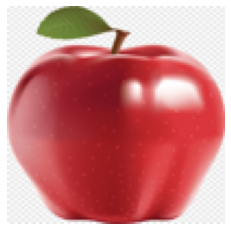

In [ ]:
download_and_predict("https://w7.pngwing.com/pngs/723/999/png-transparent-red-apple-illustration-ipod-touch-apple-icon-format-icon-red-apple-natural-foods-food-image-file-formats.png", "apple_red_delicios_1.jpg")

36.51% 	 apple_red_delicios_1
-99.19% 	 apple_red_3


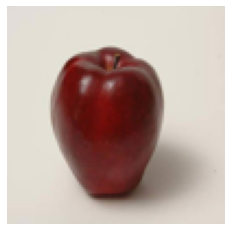

In [ ]:
download_and_predict("https://img.21food.com/20110609/product/1306988326910.jpg","apple_red_delicios_1.jpg")

96.44% 	 zucchini_dark_1
22.46% 	 apple_red_delicios_1


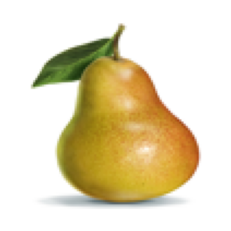

In [ ]:
download_and_predict("https://rusinfo.info/wp-content/uploads/e/3/7/e37c093de9974f20b04c88c767a9c58d.jpg","pear.jpg")

15.42% 	 zucchini_dark_1
8.33% 	 apple_red_delicios_1


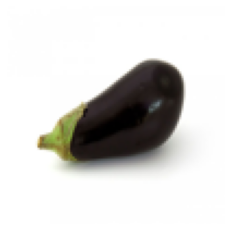

In [ ]:
download_and_predict("https://c.pxhere.com/photos/72/87/aubergine_brinjal_eggplant_vegetable_purple_culinary_raw-1136506.jpg!d","zucchini.jpg")